# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
import inflection
import datetime
import math
from IPython.display import Image
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from boruta import BorutaPy

pd.set_option('display.max_columns', None)

## 0.1 Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data\\train.csv', low_memory = False)
df_store_raw = pd.read_csv('data\\store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw,how = 'left', on ='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [4]:
df1 = df_raw.copy()

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map( snakecase, cols_old))

# rename

df1.columns = cols_new

## 1.1 Data dimension

In [6]:
print('Number of rows: ', df1.shape[0])
print('Number of columns: ', df1.shape[1])

Number of rows:  1017209
Number of columns:  18


## 1.2 Data types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.4 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)


In [11]:
# promo_interval                  508031
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug', 9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Change Types

In [13]:
df1.dtypes

change_int = ['competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']
for i in change_int:
    df1[i] = df1[i].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [15]:
# central tendency - mean/median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std )).T
d2 = pd.DataFrame(num_attributes.apply(np.min )).T
d3 = pd.DataFrame(num_attributes.apply(np.max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

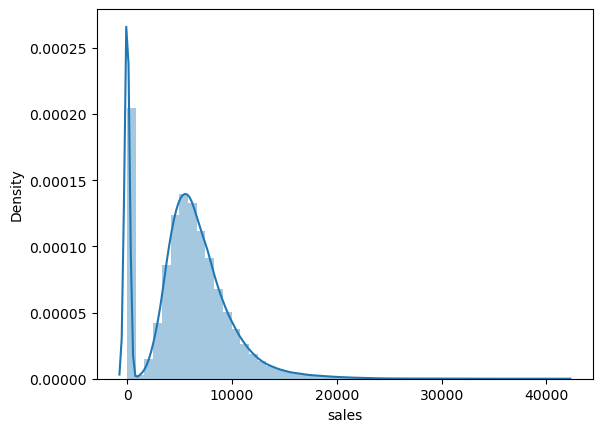

In [16]:
sns.distplot(df1['sales'])

### 1.6.2 Categorical attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

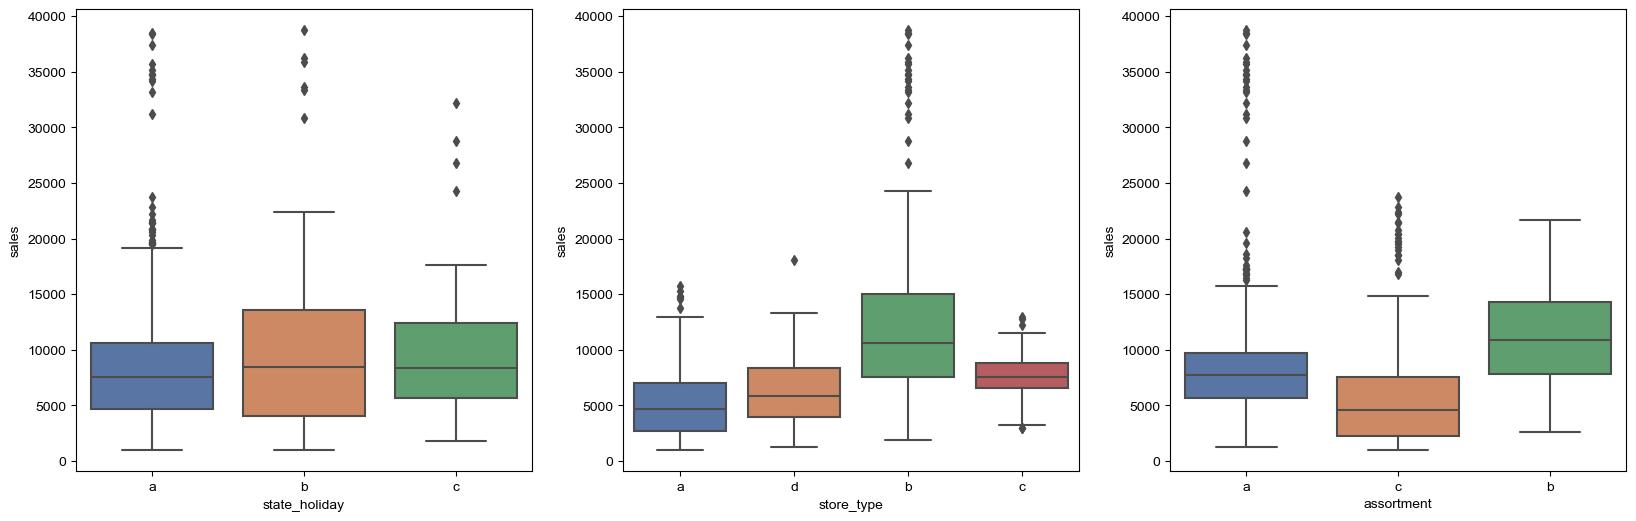

In [18]:
fig, axes = plt.subplots(1,3,figsize = (20,6))
sns.set()
aux1 = df1.loc[(df1['state_holiday'] != '0') & (df1['sales']> 0)]

sns.boxplot(x='state_holiday',y='sales', data=aux1, ax = axes[0])
sns.boxplot(x='store_type',y='sales', data=aux1, ax = axes[1])
sns.boxplot(x='assortment',y='sales', data=aux1, ax = axes[2])
plt.show()

# 2.0 Feature Engineering

## Mapa de hipoteses

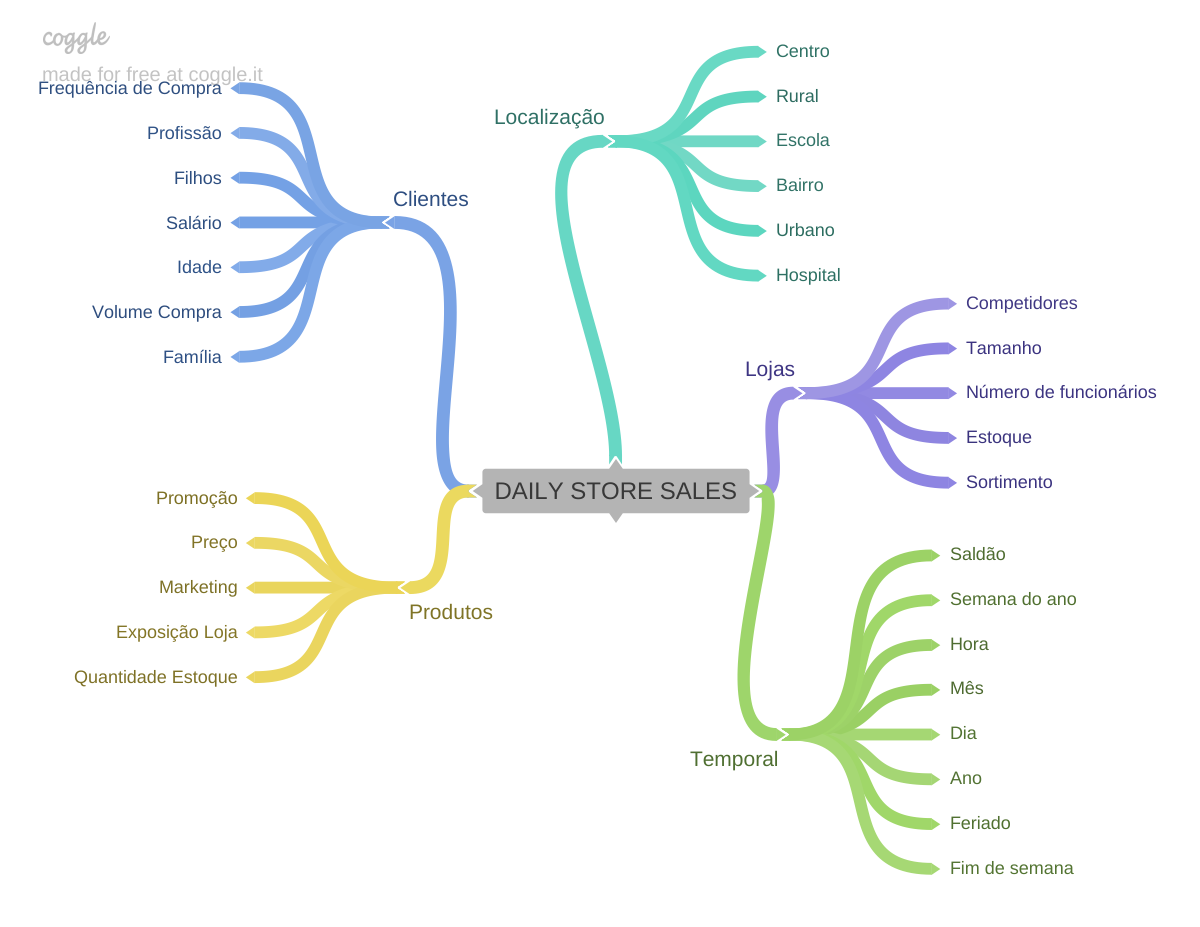

In [19]:
Image('img\\daily_store_sales.png', width = 800, height = 600)

## 2.1 Criação de hipoteses

### 2.1.0 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.1 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.2 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.


## 2.2 Lista Final de hipoteses

- Loja

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.


- Produto

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


- Tempo

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas deveriam vender menos durante feriados escolares.

## 2.3 Feature Engineering

In [20]:
# year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

#day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.weekofyear

# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')


# competition since
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month =  x['competition_open_since_month'], day = 1), axis = 1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df1['promo_time_week'] = ((df1['date'] - df1['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

#assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else
                                                            'regular_day')


C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\2813319398.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df1['week_of_year'] = df1['date'].dt.weekofyear


In [21]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0 Filtragem de variáveis

In [22]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [23]:
df1 = df1.loc[ (df1['open'] != 0) & (df1['sales'] > 0) ]


## 3.2 Seleção das colunas

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df1.drop(cols_drop, axis = 1, inplace = True)

# 4.0 Análise Exploratória dos Dados

## 4.1 Análise univariada

### 4.1.1 Response variable

C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

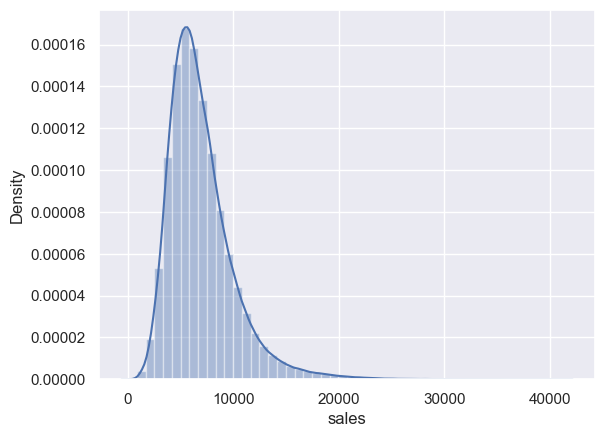

In [25]:
sns.distplot(df1['sales'])

### 4.1.2 Numerical variable

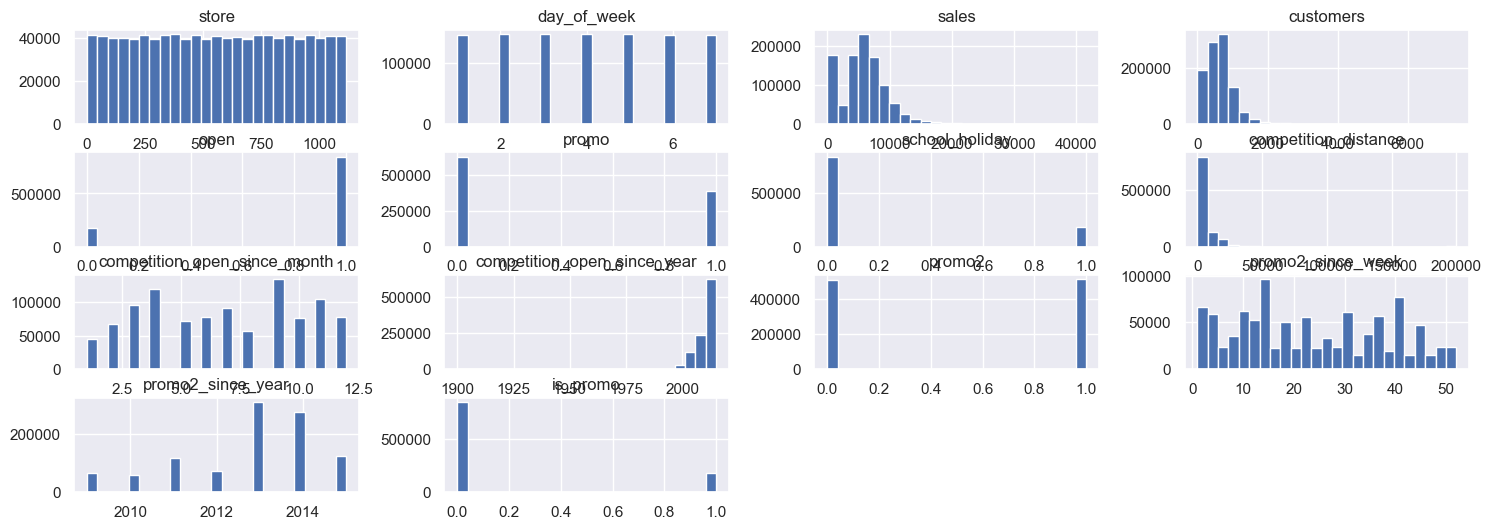

In [26]:
num_attributes.hist(figsize=(18,6), bins = 25);

### 4.1.3 Categorical variable

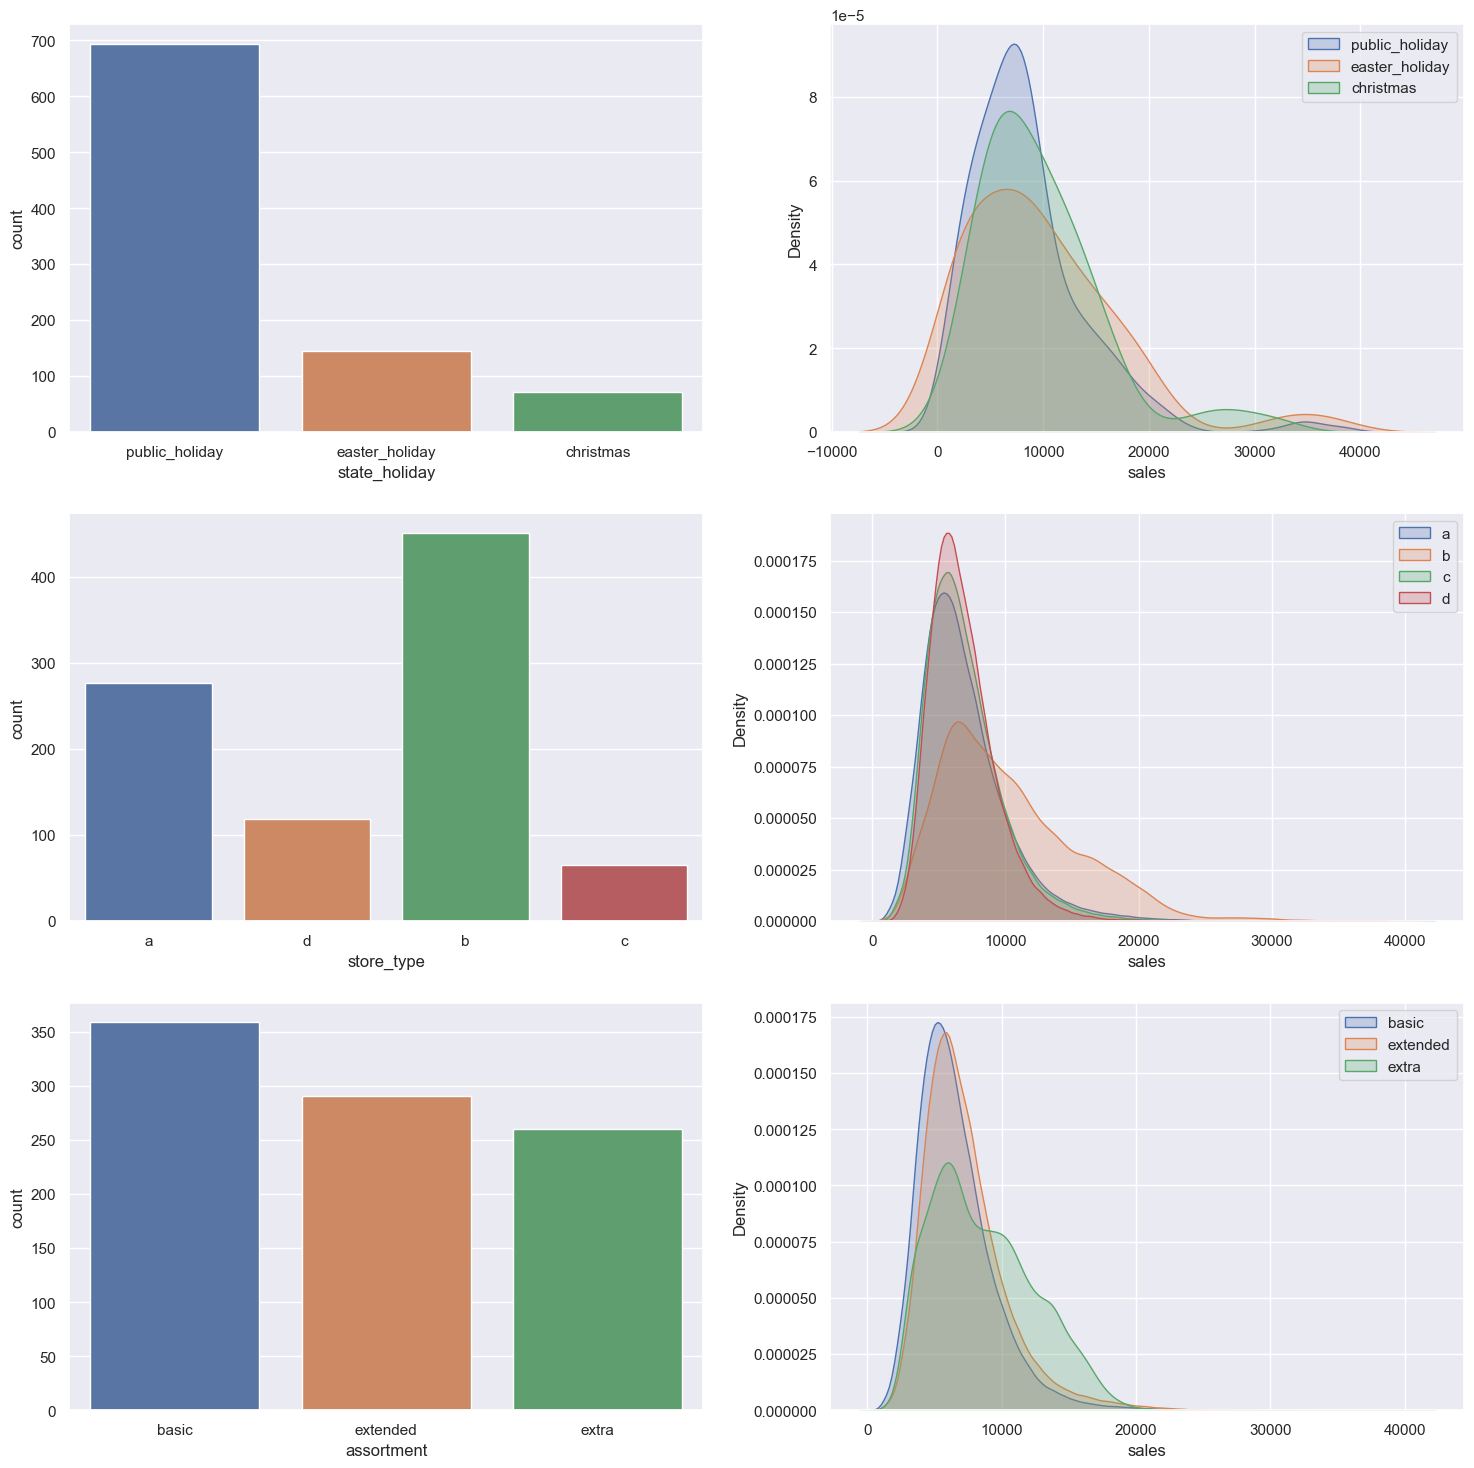

In [27]:
fig, axes = plt.subplots(3,2,figsize=(18,18))

# state holiday
a = df1[df1['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], ax = axes[0,0])

sns.kdeplot( df1[df1['state_holiday'] == 'public_holiday']['sales'], fill = True, label ='public_holiday', ax = axes[0,1], legend = True)
sns.kdeplot( df1[df1['state_holiday'] == 'easter_holiday']['sales'], fill = True, label ='easter_holiday', ax = axes[0,1], legend = True)
sns.kdeplot( df1[df1['state_holiday'] == 'christmas']['sales'], fill = True, label ='christmas', ax = axes[0,1], legend = True)

# store type
sns.countplot(x=a['store_type'], ax = axes[1,0])
sns.kdeplot( df1[df1['store_type'] == 'a']['sales'], fill = True, label ='a', ax = axes[1,1], legend = True)
sns.kdeplot( df1[df1['store_type'] == 'b']['sales'], fill = True, label ='b', ax = axes[1,1],legend = True)
sns.kdeplot( df1[df1['store_type'] == 'c']['sales'], fill = True, label ='c', ax = axes[1,1],legend = True)
sns.kdeplot( df1[df1['store_type'] == 'd']['sales'], fill = True, label ='d', ax = axes[1,1],legend = True)
axes[1,1].legend()
axes[0,1].legend()

# assortment
sns.countplot(x=a['assortment'], ax = axes[2,0])
sns.kdeplot( df1[df1['assortment'] == 'basic']['sales'], fill = True, label ='basic', ax = axes[2,1], legend = True)
sns.kdeplot( df1[df1['assortment'] == 'extended']['sales'], fill = True, label ='extended', ax = axes[2,1],legend = True)
sns.kdeplot( df1[df1['assortment'] == 'extra']['sales'], fill = True, label ='extra', ax = axes[2,1],legend = True)
axes[2,1].legend()

## 4.2 Análise bivariada

### H1 Lojas com maior sortimento deveriam vender mais

**FALSA** lojas com MAIOR sortimento, vendem MENOS.

<AxesSubplot:xlabel='year_week'>

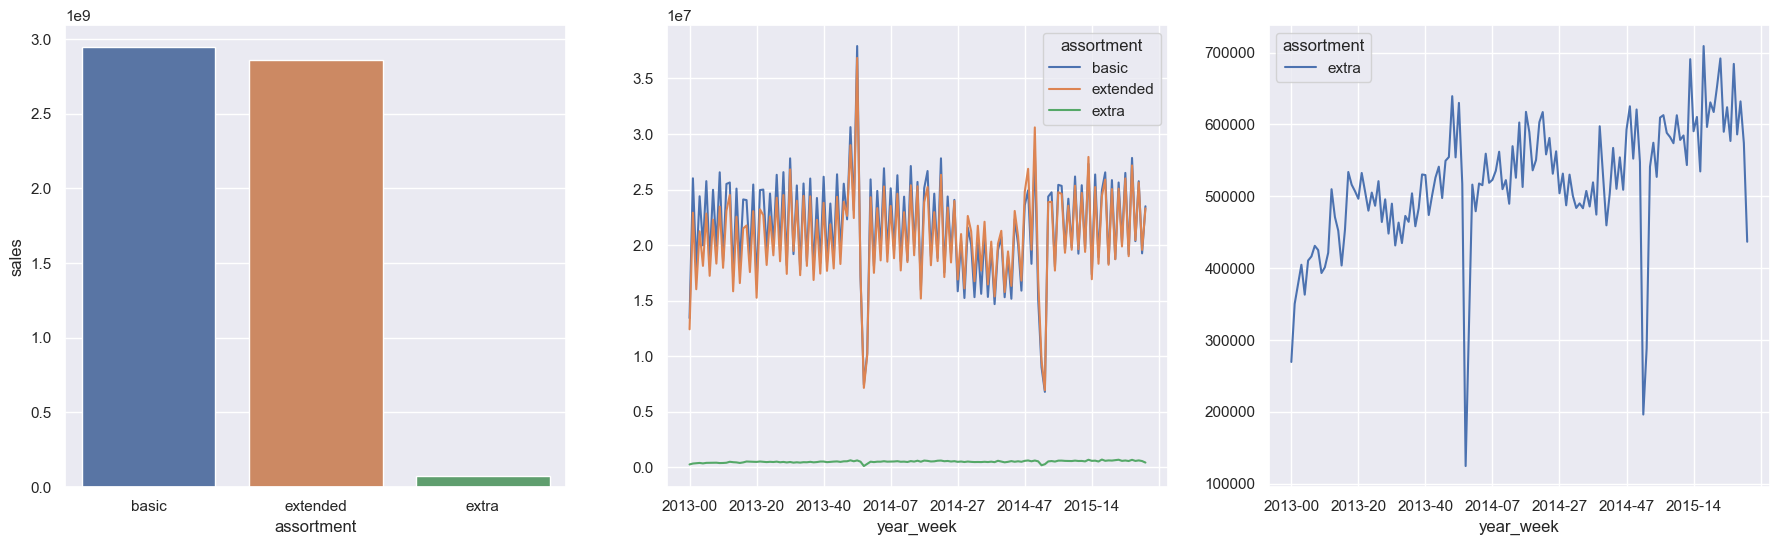

In [28]:
fig, axes = plt.subplots(1,3,figsize = (22,6))
aux1 = df1[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y ='sales', data = aux1, ax = axes[0])


aux2 = df1[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum(). reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(ax= axes[1])


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(ax = axes[2])

### H2 Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com competidores mais próximos, vendem mais

In [29]:
# aux1 = df1[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\988699742.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);


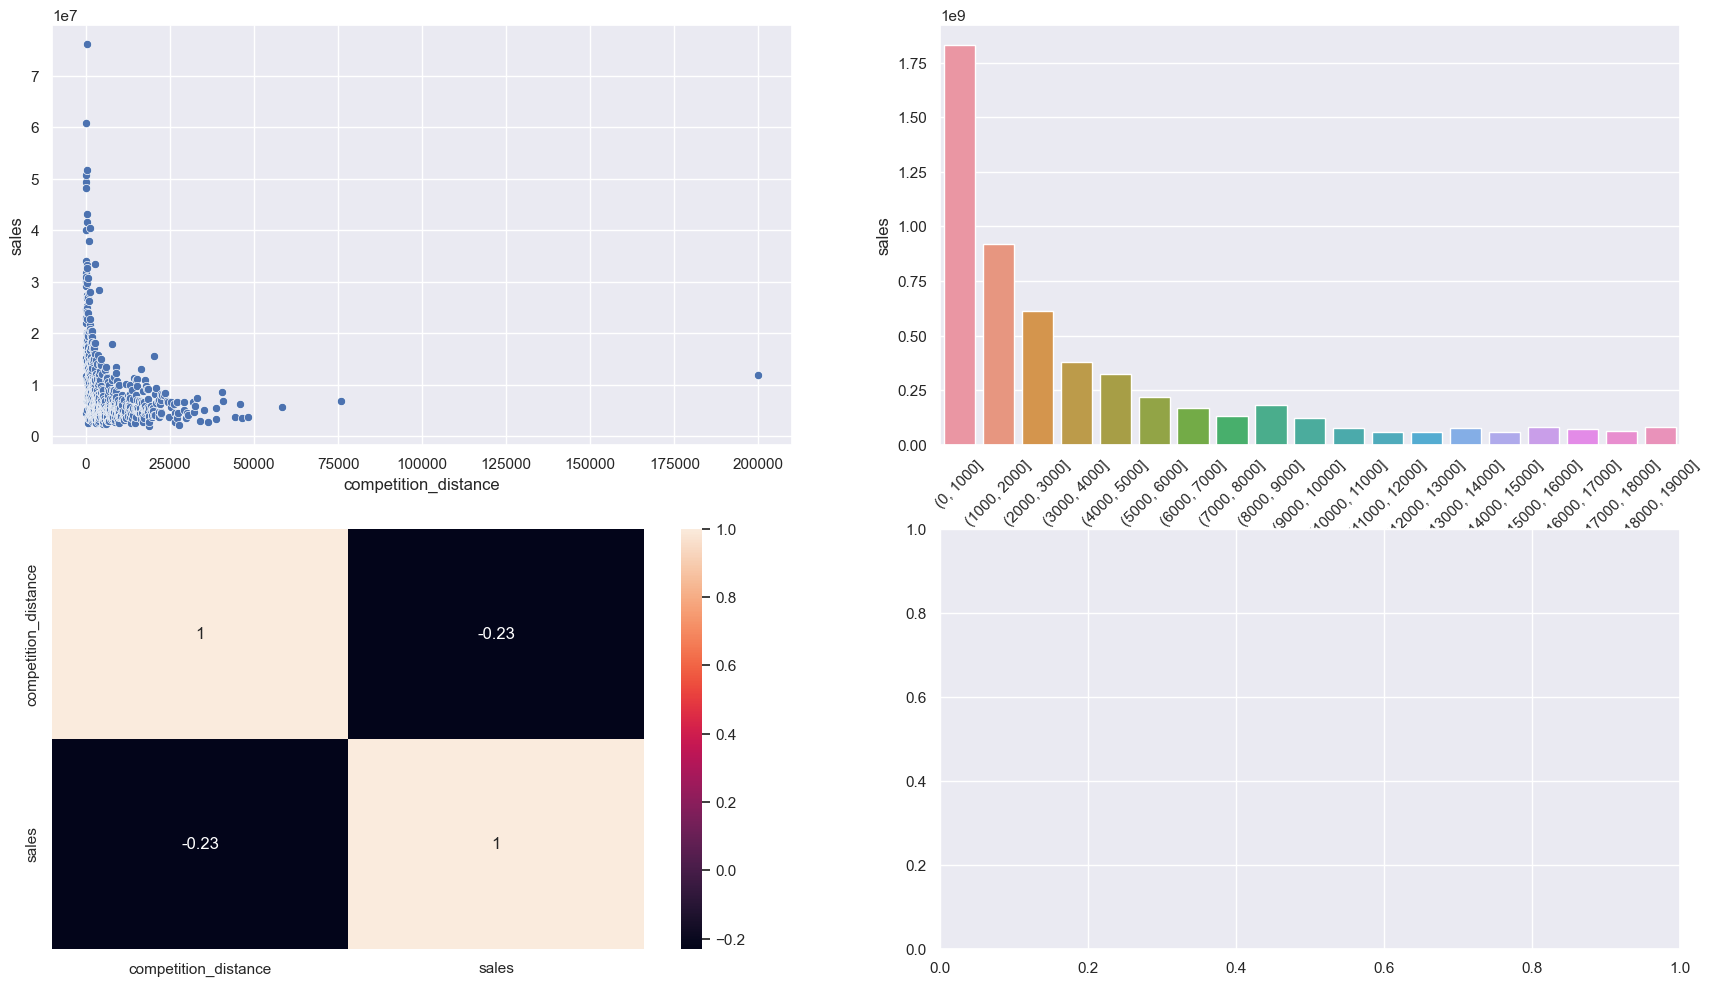

In [30]:
fig, axes = plt.subplots(2,2,figsize = (21,12))
aux1 = df1[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1, ax = axes[0,0]);


bins = list(np.arange(0, 20000,1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1.groupby(['competition_distance_binned'], as_index = False)['sales'].sum()
sns.barplot(x = 'competition_distance_binned', y= 'sales', data = aux2, ax = axes[0,1]);
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);

### H3 Lojas com competidores a mais tempo deveriam vender mais

**FALSA** Lojas com competidores a mais tempo vendem menos

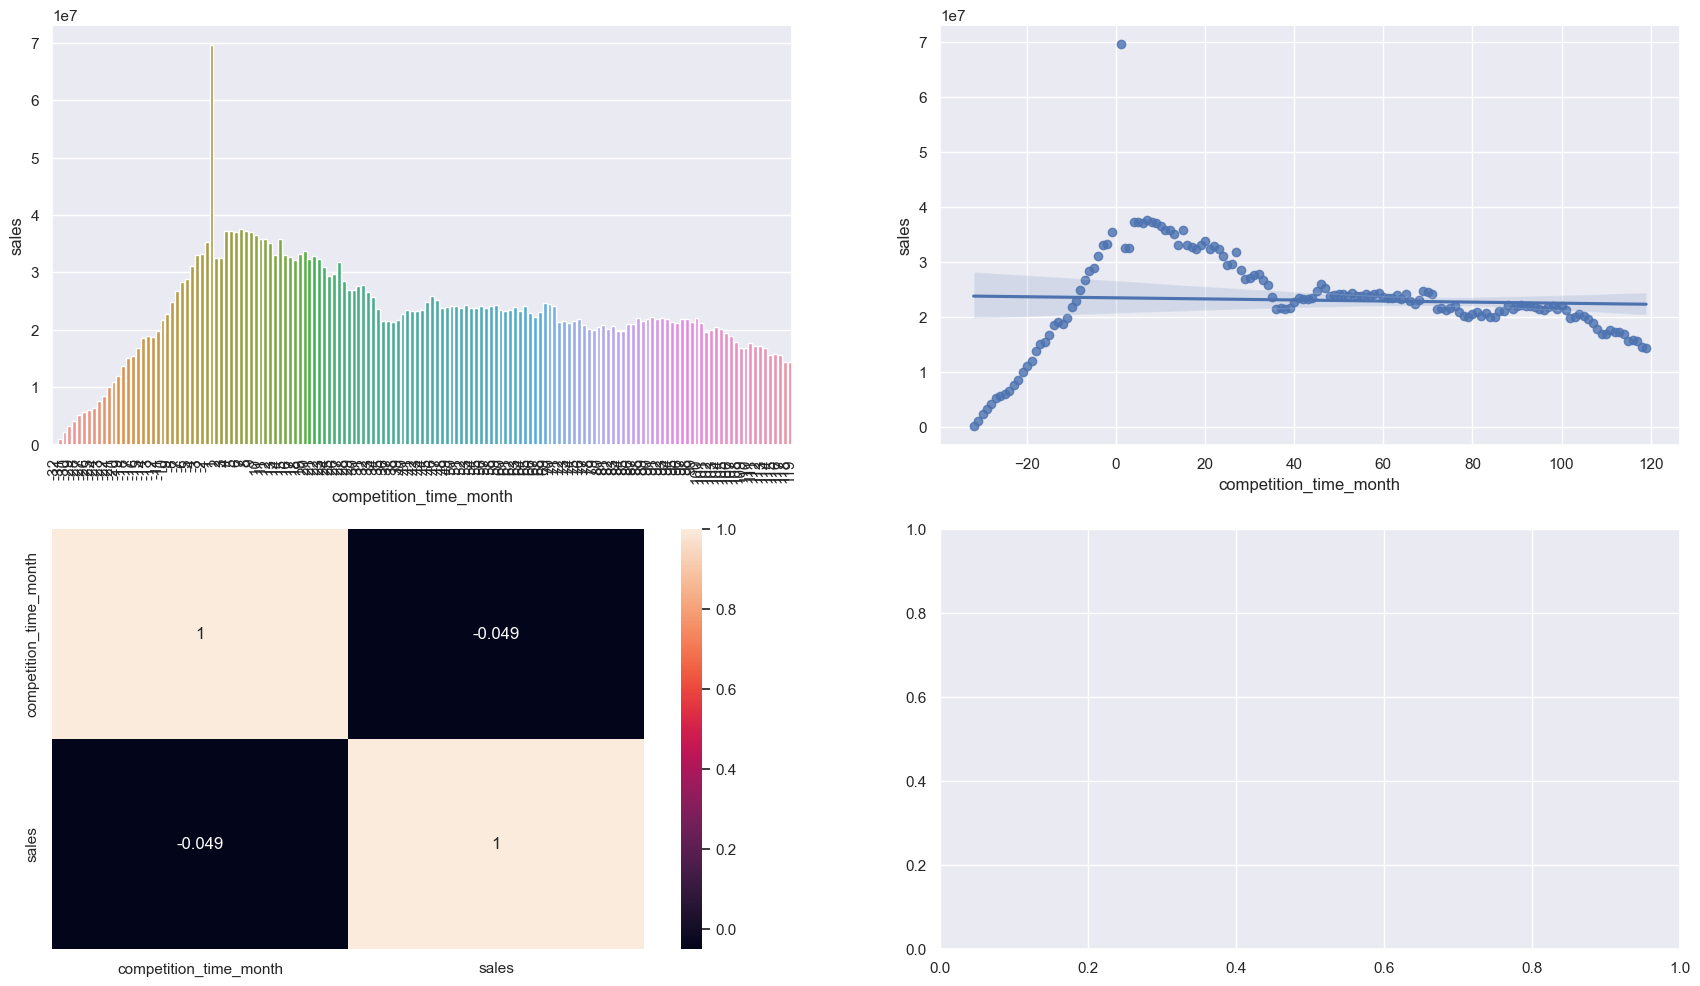

In [31]:
fig, axes = plt.subplots(2,2,figsize = (21,12))

aux1 = df1[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1.loc[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2, ax = axes[0,0]);
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation = 90);


sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2, ax = axes[0,1]);

sns.heatmap(aux2.corr(method = 'pearson'), annot = True, ax = axes[1,0]);

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais


**FALSA** Lojas com promoções ativas vendem menos

C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\3485774898.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 90);
C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\3485774898.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation = 90);


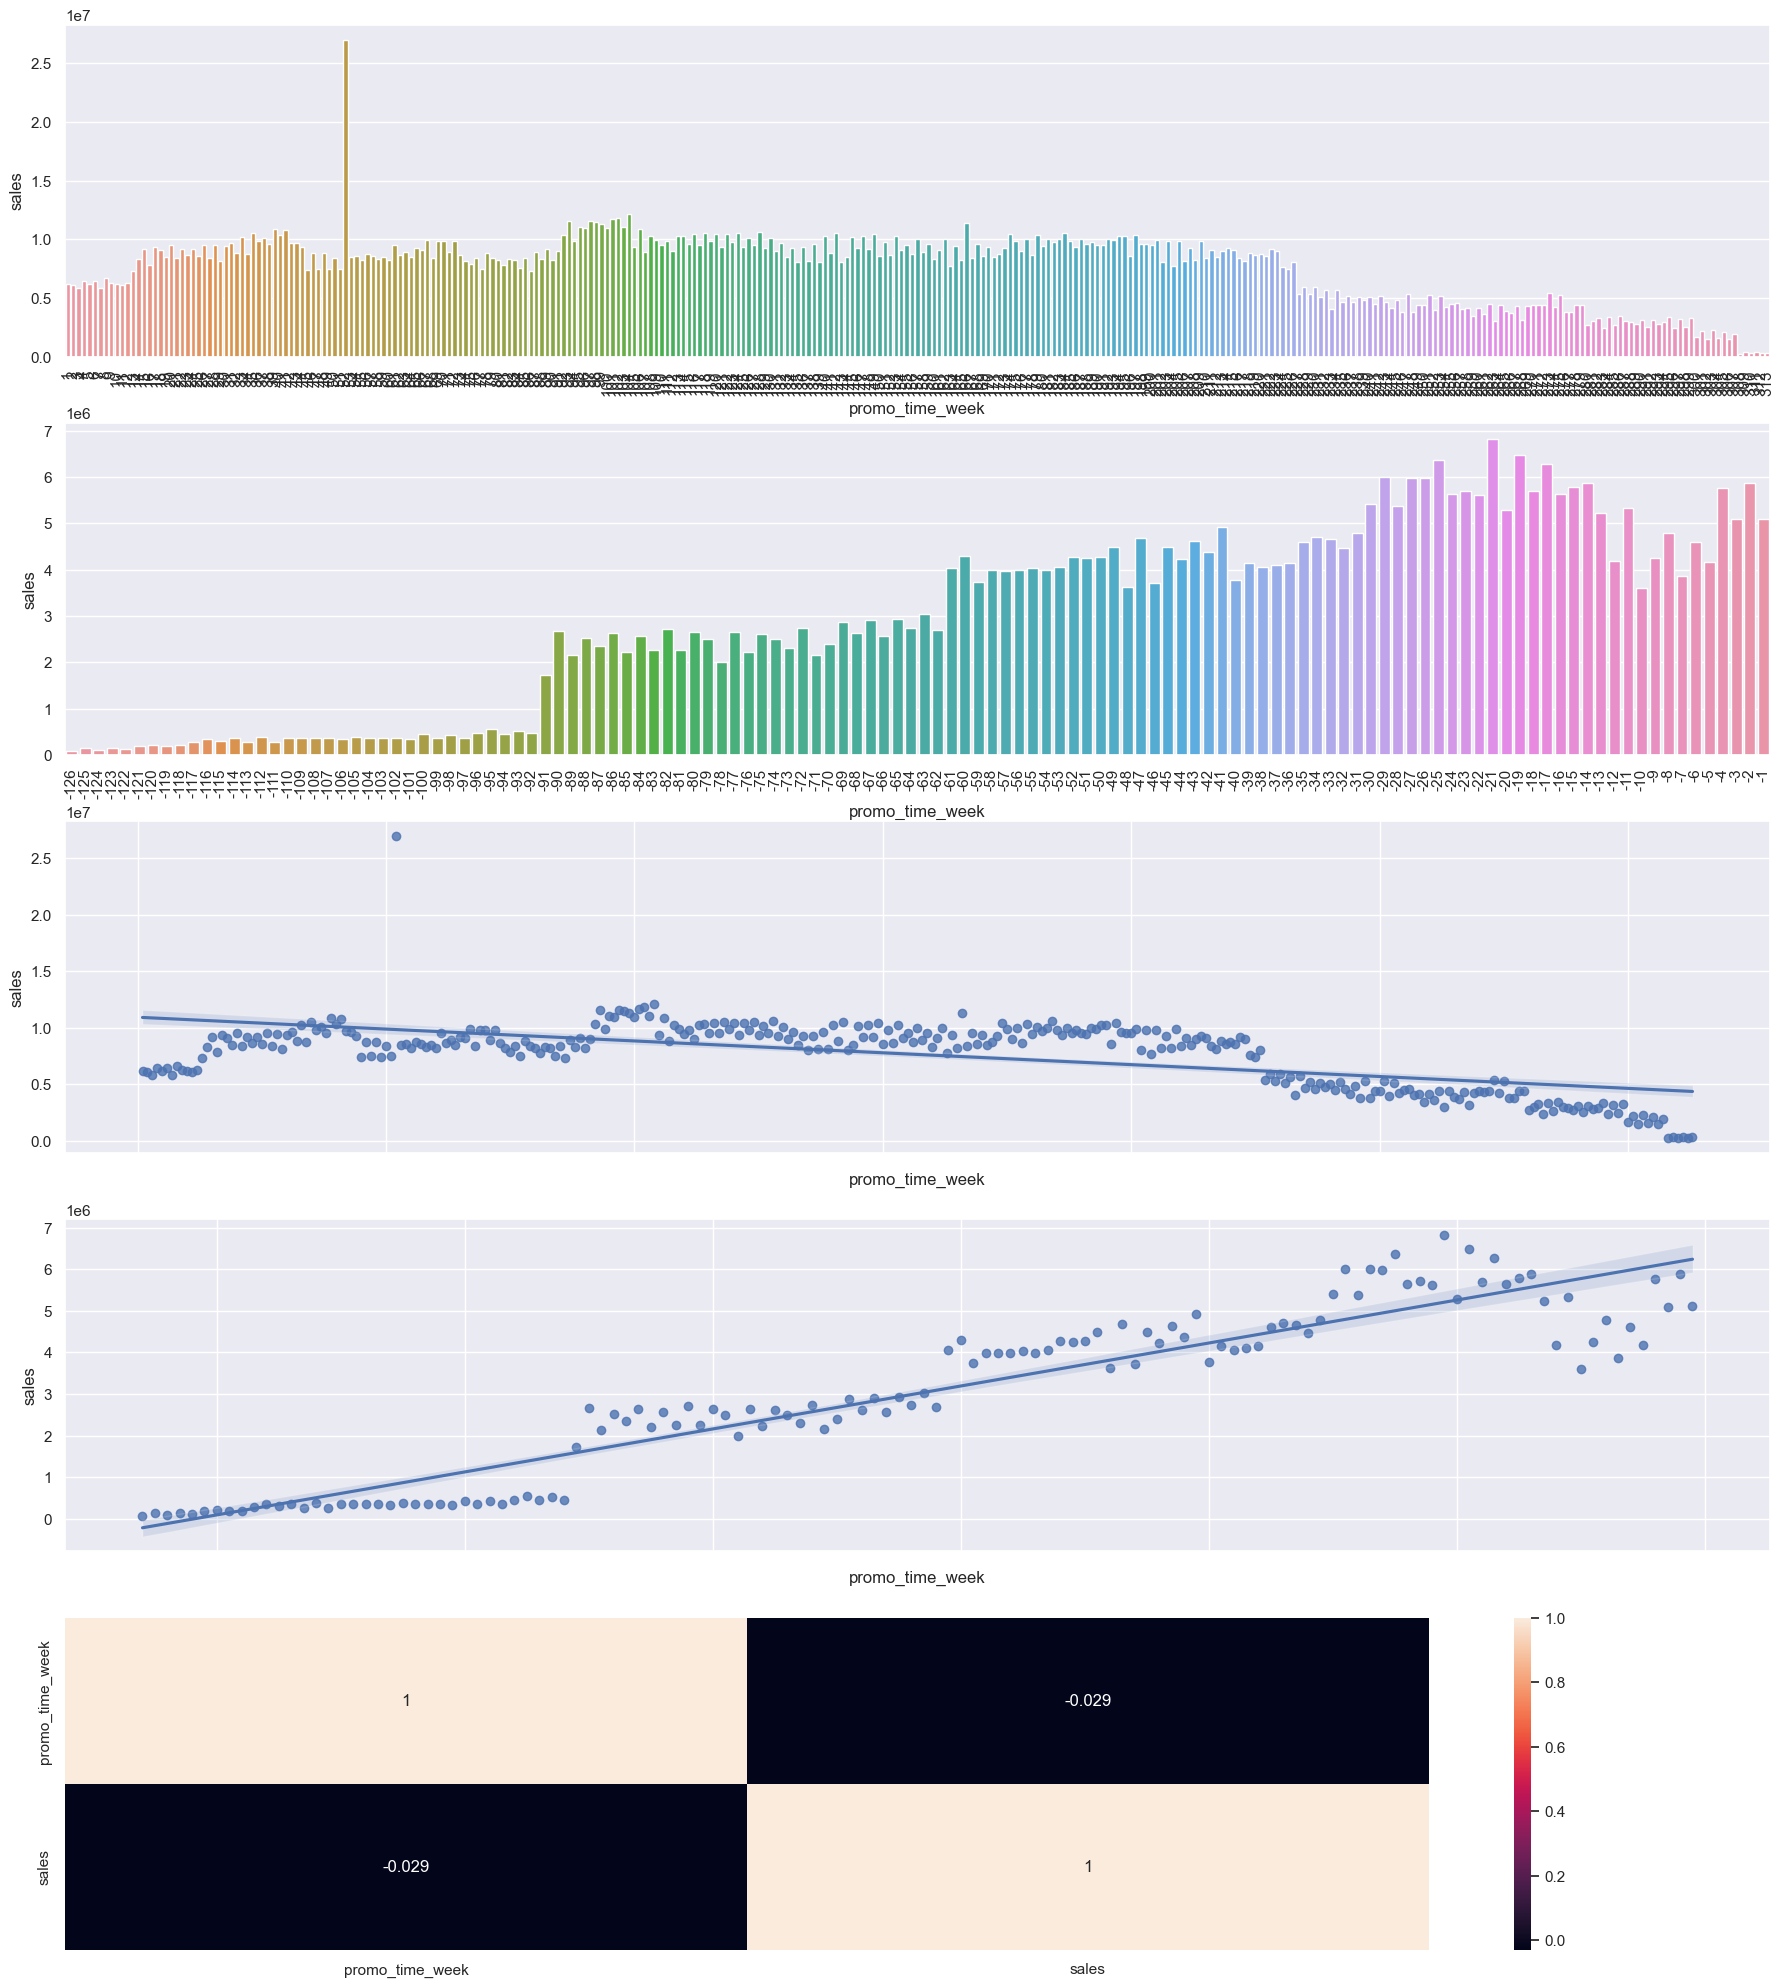

In [32]:
fig, axes = plt.subplots(5,1, figsize = (22,25))
aux1 = df1[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

# sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1, ax = axes)
# axes.set_xticklabels(axes.get_xticklabels(), rotation = 90);

aux2 = aux1.loc[aux1['promo_time_week'] > 0] # promo extendido
aux3 = aux1.loc[aux1['promo_time_week'] < 0] # promo regular


sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2, ax = axes[0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3, ax = axes[1])

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 90);
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 90);

sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2, ax = axes[2])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3, ax = axes[3])

axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 90);
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation = 90);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[4]);

### <s>H5 Lojas com mais dias de promoção deveriam vender mais</s>


### H6 Lojas com mais promoções consecutivas deveriam vender mais

**FALSA** Lojas com promoções consecutivas vendem menos

In [33]:
df1[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


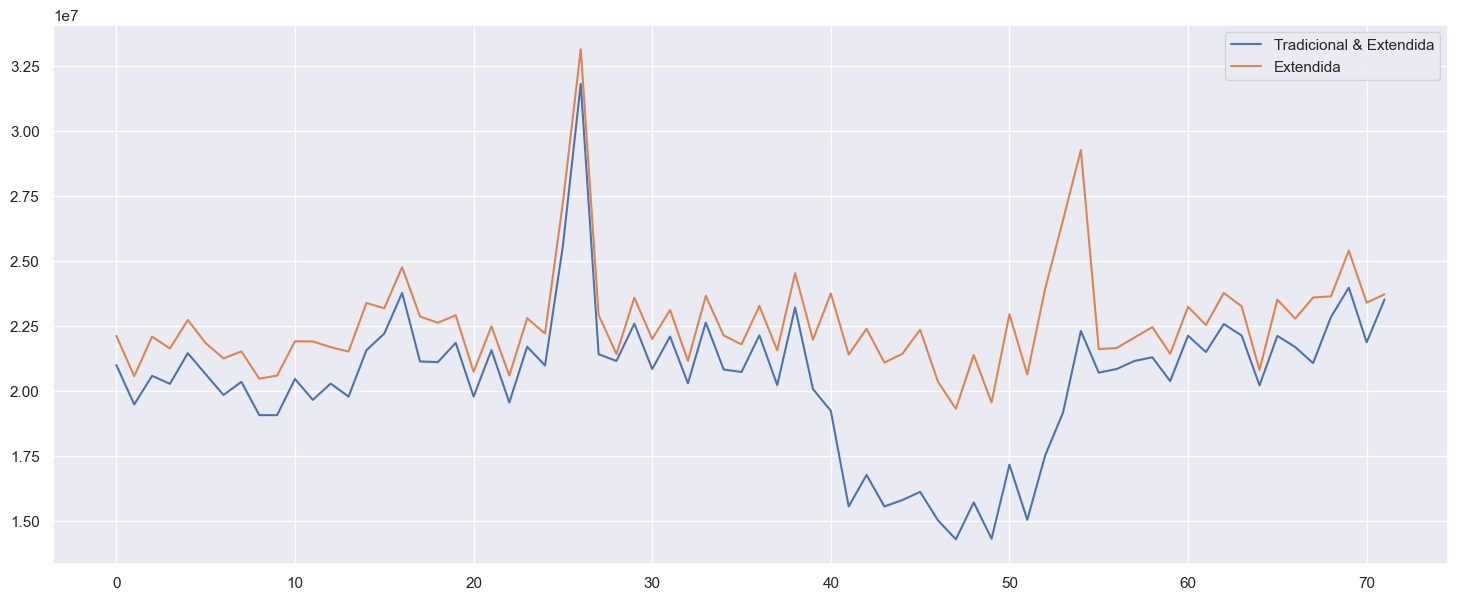

In [34]:
aux1 = df1[(df1['promo'] == 1) & (df1['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(18,7))

aux2 = df1[(df1['promo'] == 1) & (df1['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

### H7 Lojas abertas durante o Natal deveriam vender mais

**FALSA** Lojas abertas durante o NATAL vendem menos.

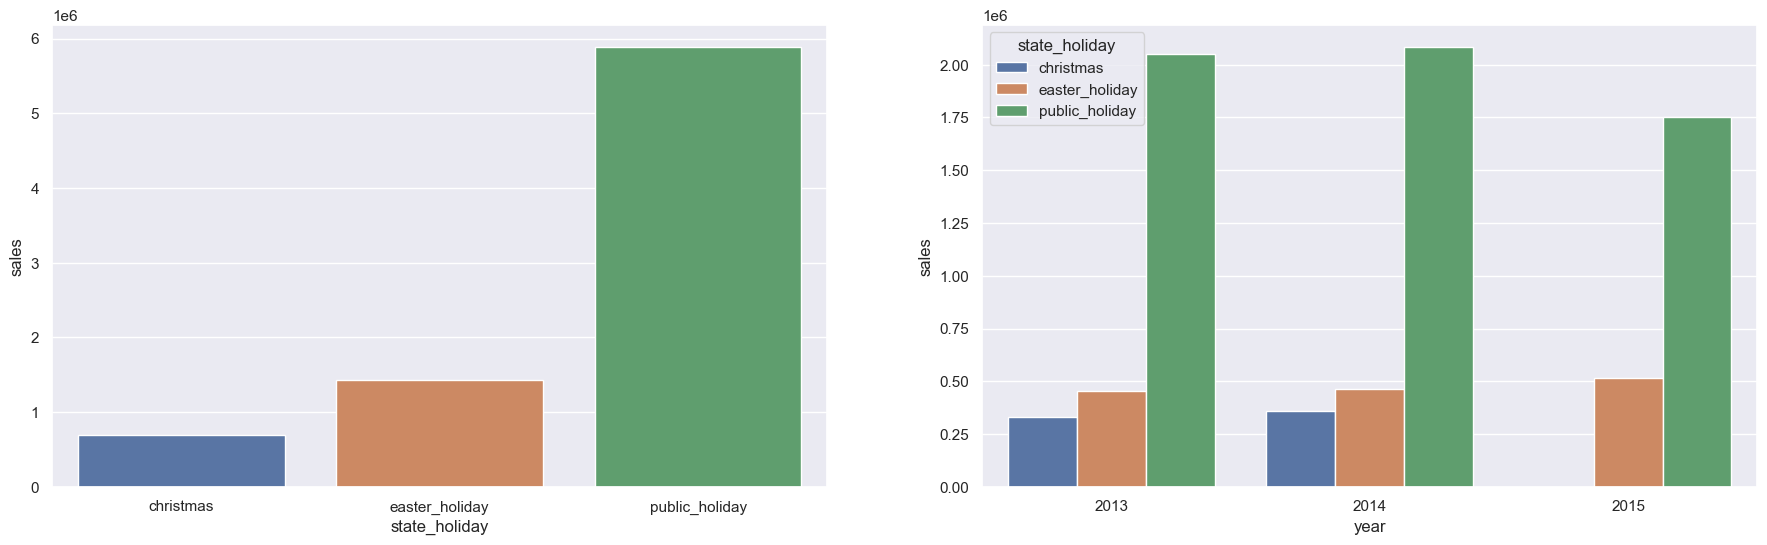

In [35]:
fig, axes = plt.subplots(1,2,figsize = (22,6))

aux = df1.loc[df1['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0]);

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday',data = aux2, ax = axes[1]);


### H8 Lojas deveriam vender mais ao longo dos anos

**FALSA** Lojas vendem menos ao passar dos anos.

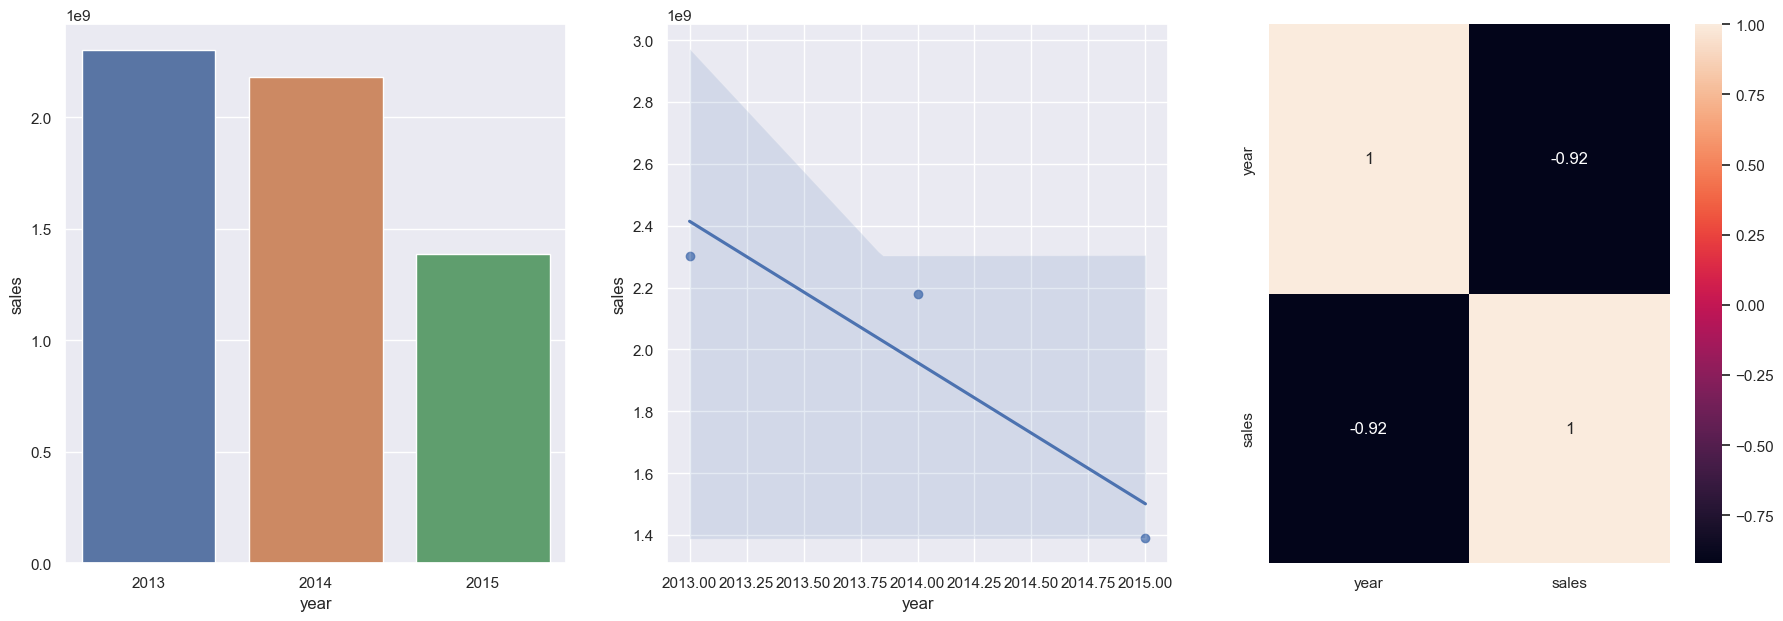

In [36]:
fig, axes = plt.subplots(1,3,figsize = (22,7))

aux1 = df1[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales',data = aux1, ax = axes[0]);

sns.regplot(x = 'year', y = 'sales',data = aux1, ax = axes[1]);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[2]);

### H9 Lojas deveriam vender mais no segundo semestre do ano

**FALSA**


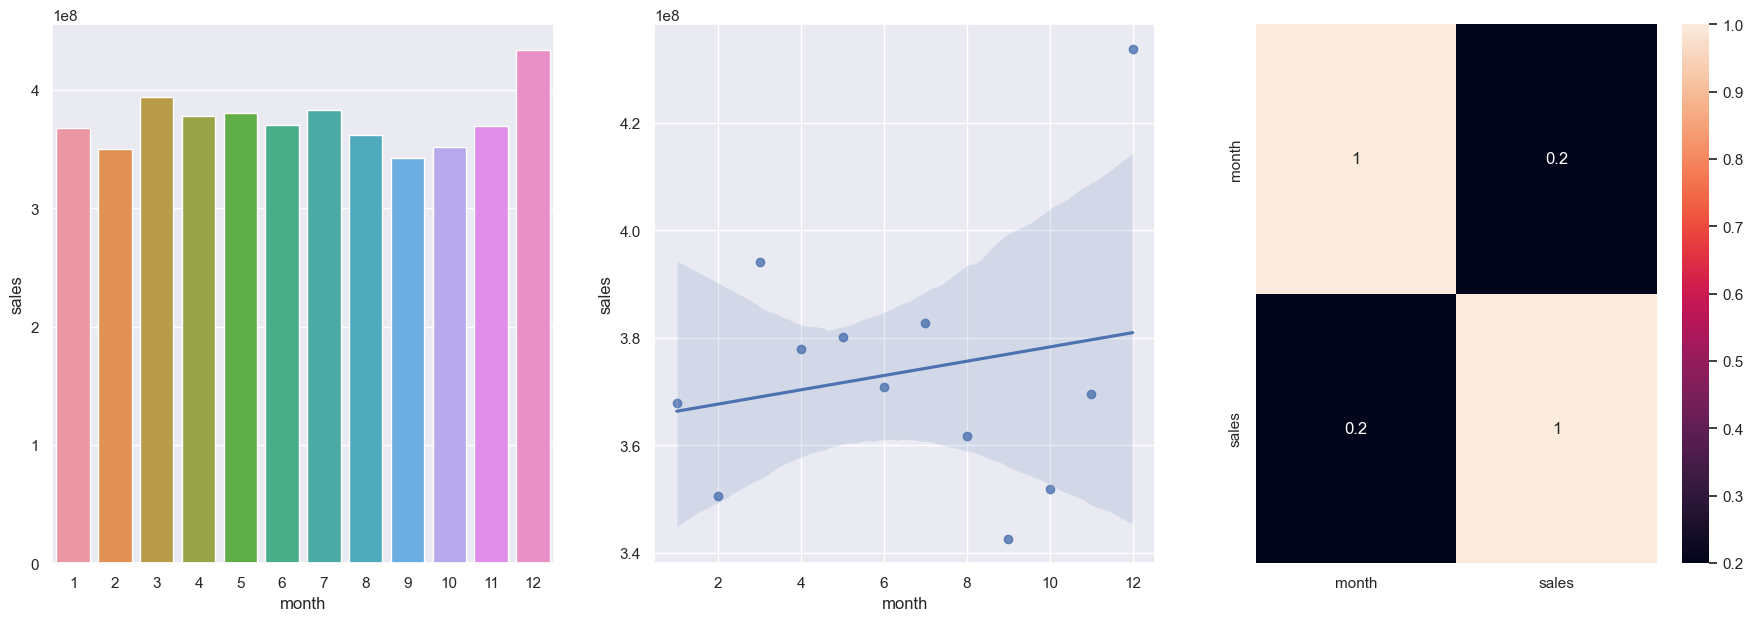

In [37]:
fig, axes = plt.subplots(1,3,figsize = (22,7))

aux = df1.loc[df1['year'] < 2015]
aux1 = aux[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales',data = aux1, ax = axes[0]);

sns.regplot(x = 'month', y = 'sales',data = aux1, ax = axes[1]);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[2]);

### H10 Lojas deveriam vender mais depois do dia 10 de cada mês

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

C:\Users\pedro\AppData\Local\Temp\ipykernel_4792\993260123.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);


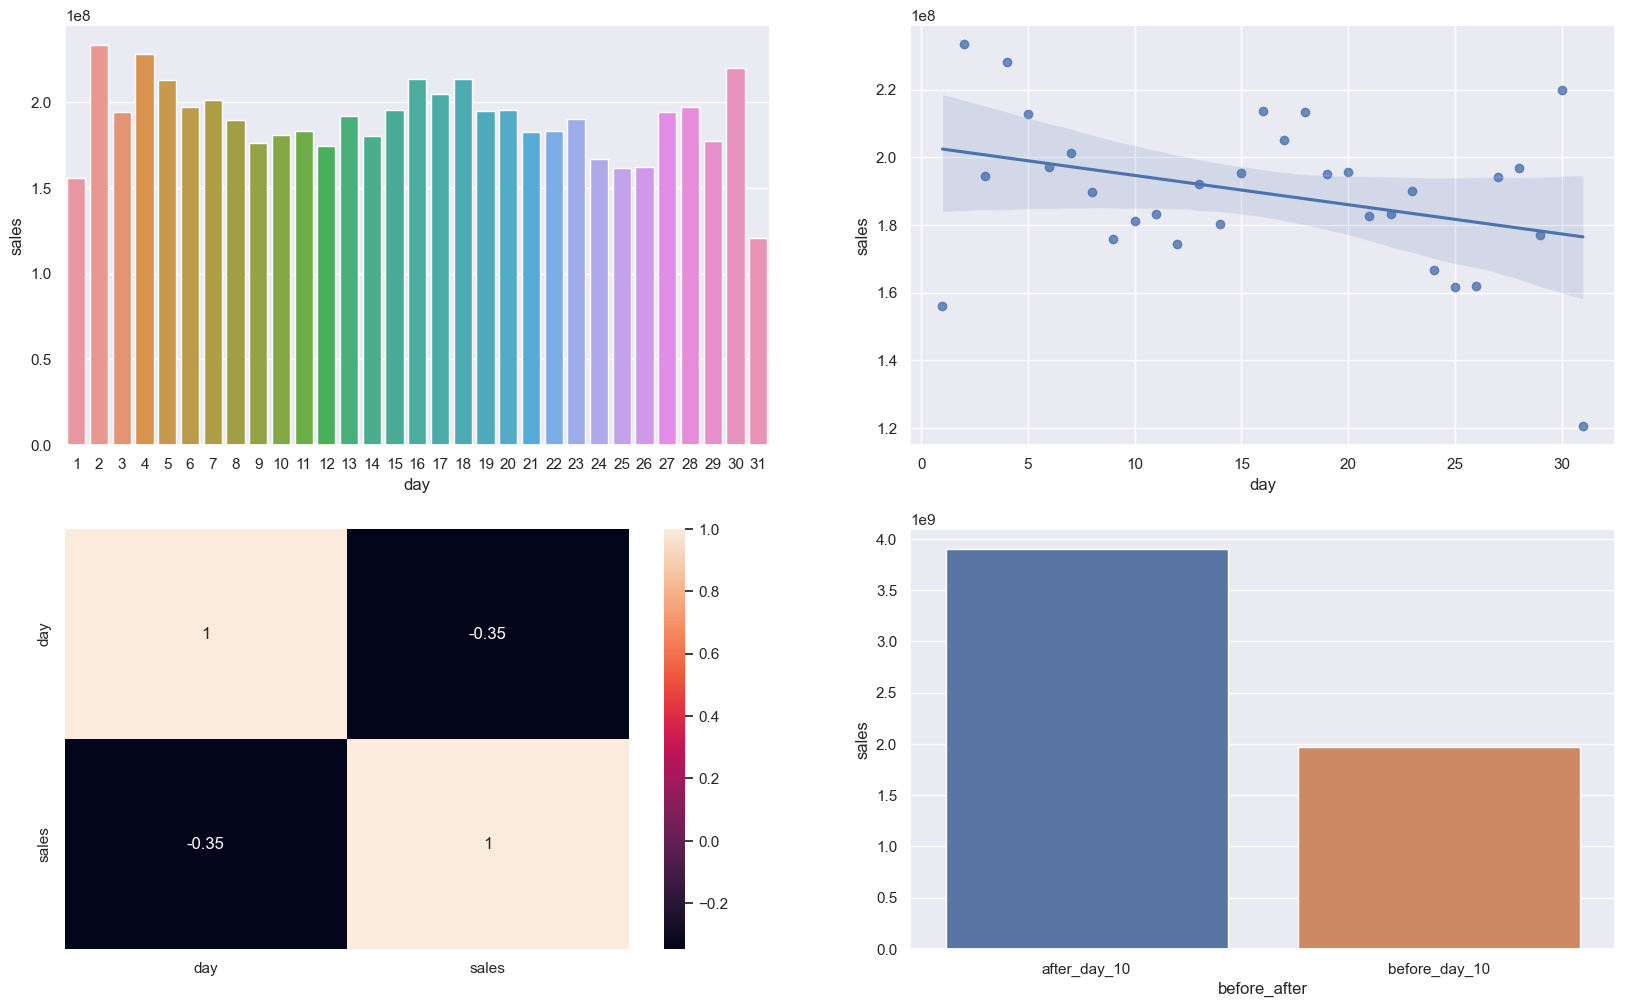

In [38]:
fig, axes = plt.subplots(2,2,figsize = (20,12))

# aux = df1.loc[df1['day'] < 2015]
aux1 = df1[['day','sales']].groupby('day').sum().reset_index()

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10' )


sns.barplot(x = 'day', y = 'sales',data = aux1, ax = axes[0,0]);

sns.regplot(x = 'day', y = 'sales',data = aux1, ax = axes[0,1]);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);


aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales',data = aux2, ax = axes[1,1]);

### H11 Lojas deveriam vender menos aos finais de semana

**VERDADEIRA** Lojas vendem menos nos finais de semana

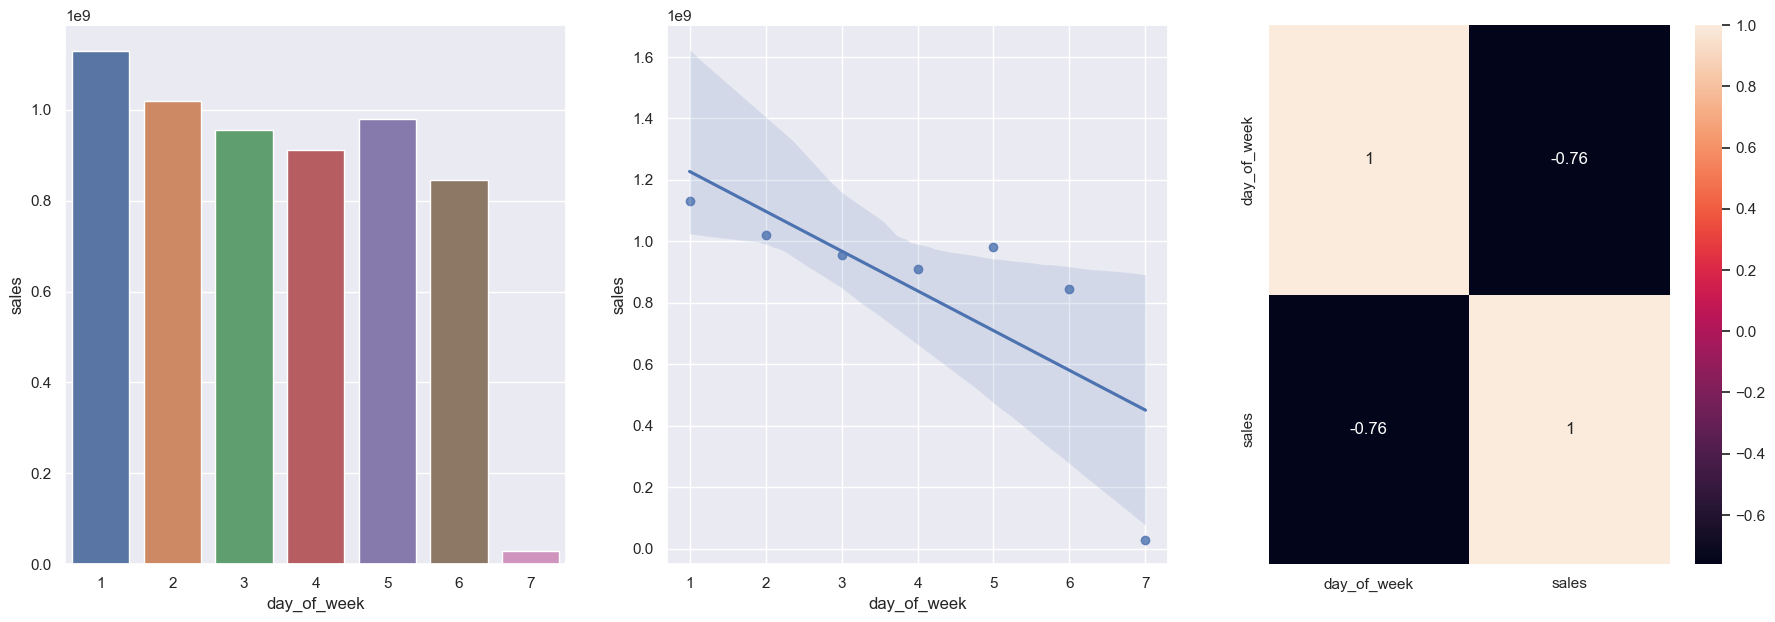

In [39]:
fig, axes = plt.subplots(1,3,figsize = (22,7))

# aux = df1.loc[df1['year'] < 2015]
aux1 = df1[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales',data = aux1, ax = axes[0]);

sns.regplot(x = 'day_of_week', y = 'sales',data = aux1, ax = axes[1]);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[2]);

### H12 Lojas deveriam vender menos durante feriados escolares

**VERDADEIRA** Lojas vendem menos quando é feriado escolar, exceto JULHO e AGOSTO

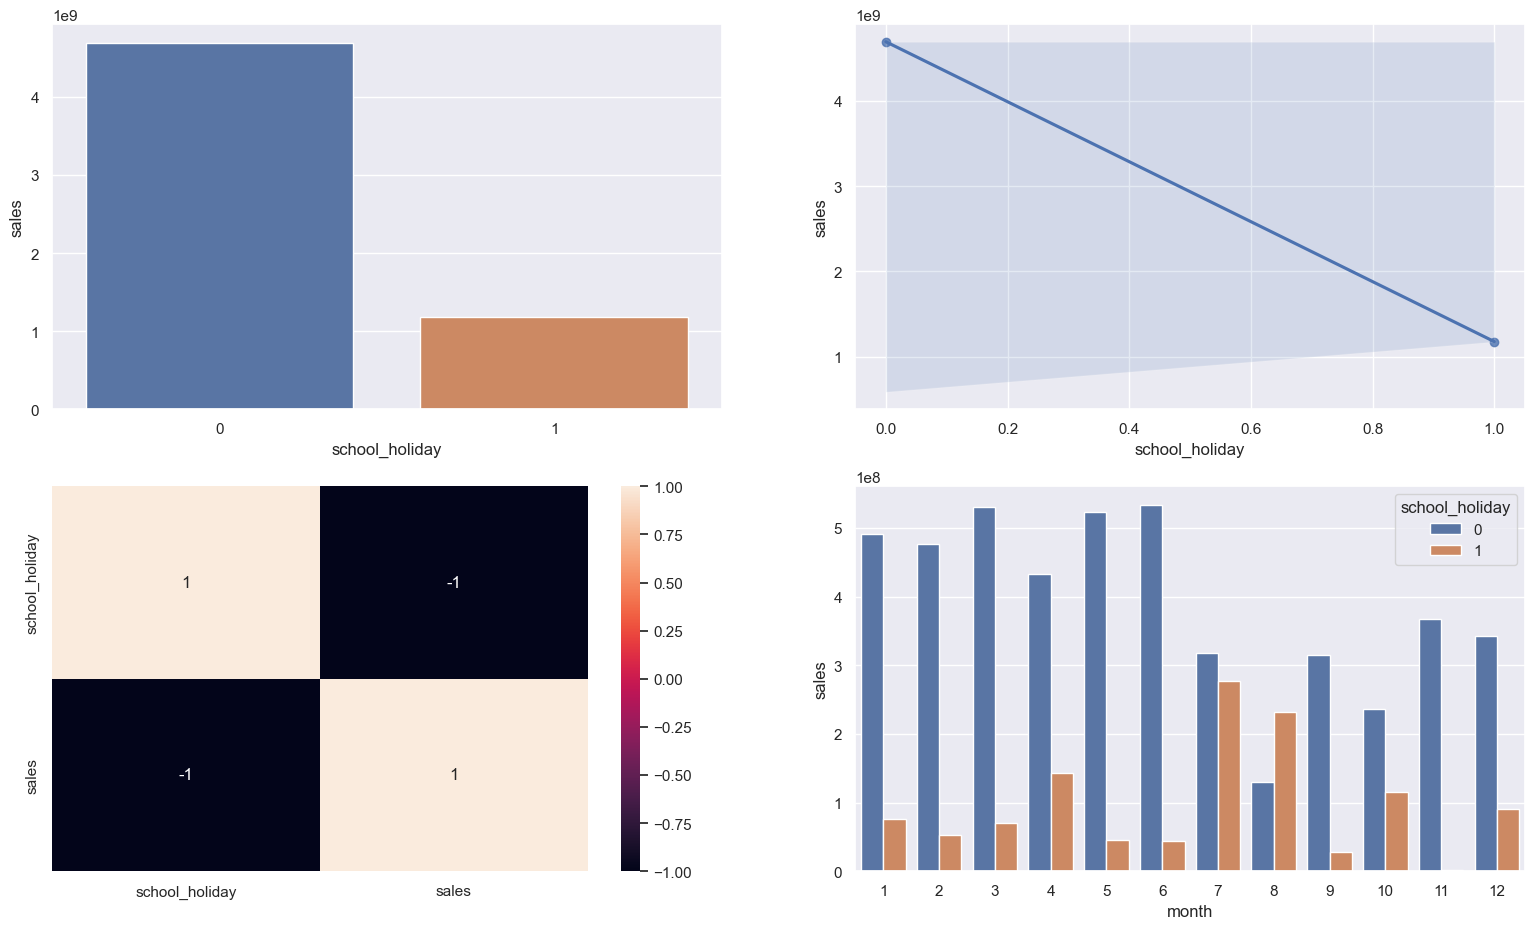

In [40]:
fig, axes = plt.subplots(2,2,figsize = (19,11))

# aux = df1.loc[df1['year'] < 2015]
aux1 = df1[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales',data = aux1, ax = axes[0,0]);

sns.regplot(x = 'school_holiday', y = 'sales',data = aux1, ax = axes[0,1]);

sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = axes[1,0]);


aux2 = df1[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales',hue = 'school_holiday',data = aux2, ax = axes[1,1]);


### Resumo hipoteses

In [41]:
from tabulate import tabulate

In [42]:
tab = [
     ['Hipotese',' Conclusao','Relevancia'],
     ['H1',' Falsa','Baixa'],
     ['H2',' Falsa','Media'],
     ['H3',' Falsa','Media'],
     ['H4',' Falsa','Baixa'],
     ['H5',' -','-'],
     ['H6',' Falsa','Baixa'],
     ['H7',' Falsa','Media'],
     ['H8',' Falsa','Alta'],
     ['H9',' Falsa','Alta'],
     ['H10',' Falsa','Alta'],
     ['H11',' Verdadeira','Alta'],
     ['H12',' Verdadeira','Alta'],
     ['H13',' Verdadeira','Baixa'],

]
print(tabulate( tab, headers='firstrow'))

Hipotese     Conclusao    Relevancia
----------  ------------  ------------
H1          Falsa         Baixa
H2          Falsa         Media
H3          Falsa         Media
H4          Falsa         Baixa
H5          -             -
H6          Falsa         Baixa
H7          Falsa         Media
H8          Falsa         Alta
H9          Falsa         Alta
H10         Falsa         Alta
H11         Verdadeira    Alta
H12         Verdadeira    Alta
H13         Verdadeira    Baixa


## 4.3 Análise multivariada

### Numerical attributes

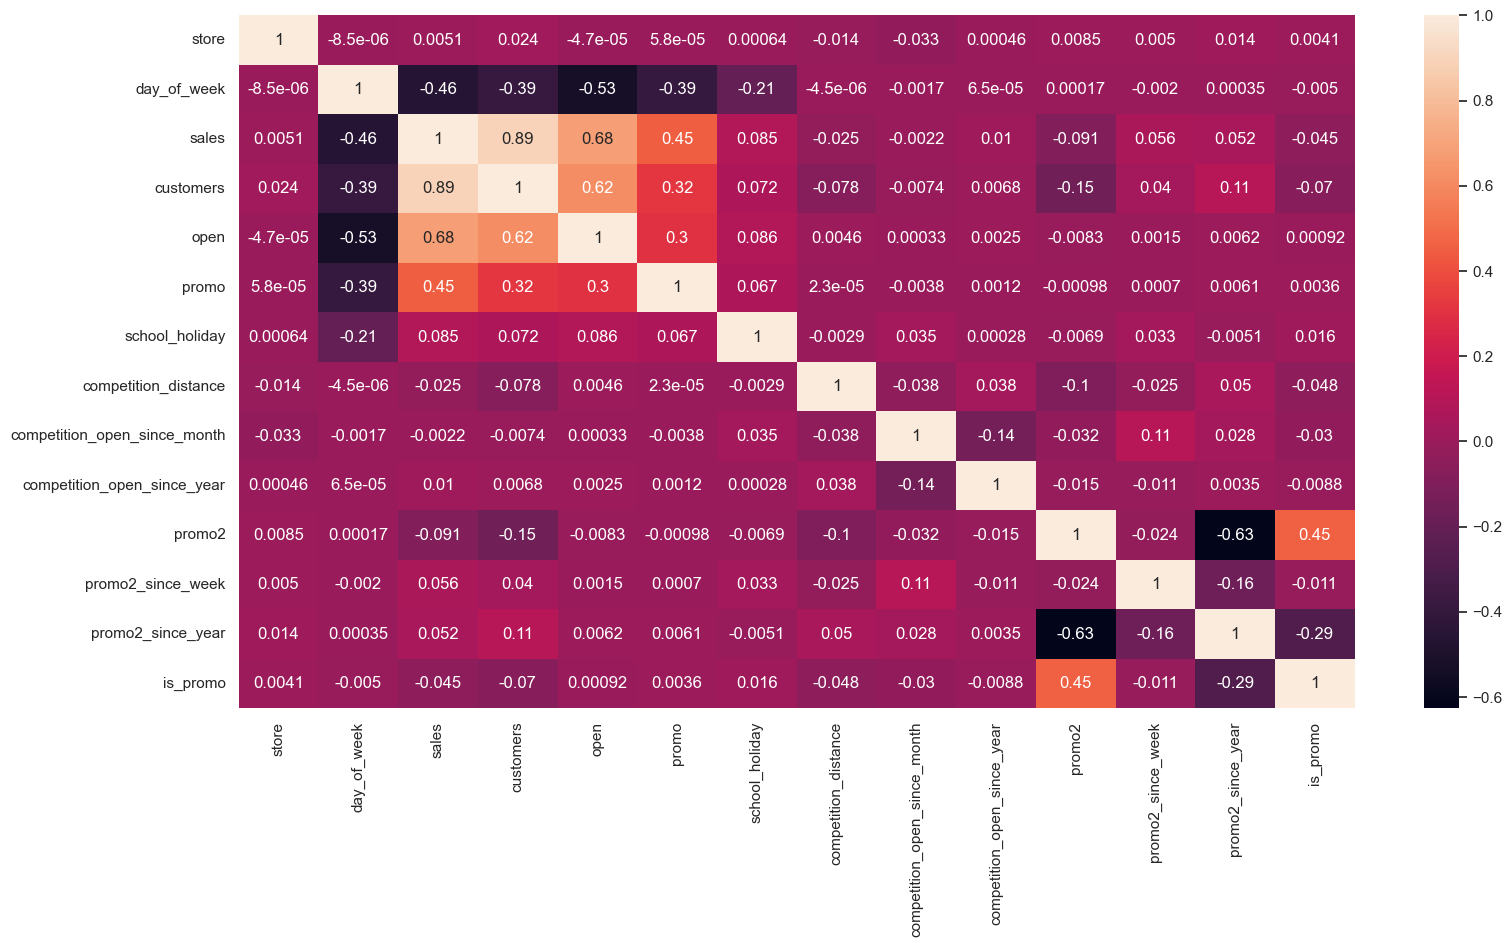

In [43]:
correlation = num_attributes.corr(method = 'pearson')
fig, axes = plt.subplots(1,1,figsize=(18,9))
sns.heatmap(correlation, annot = True, ax = axes);

### Categorical attributes

In [44]:
a = df1.select_dtypes(include = 'object')
a

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


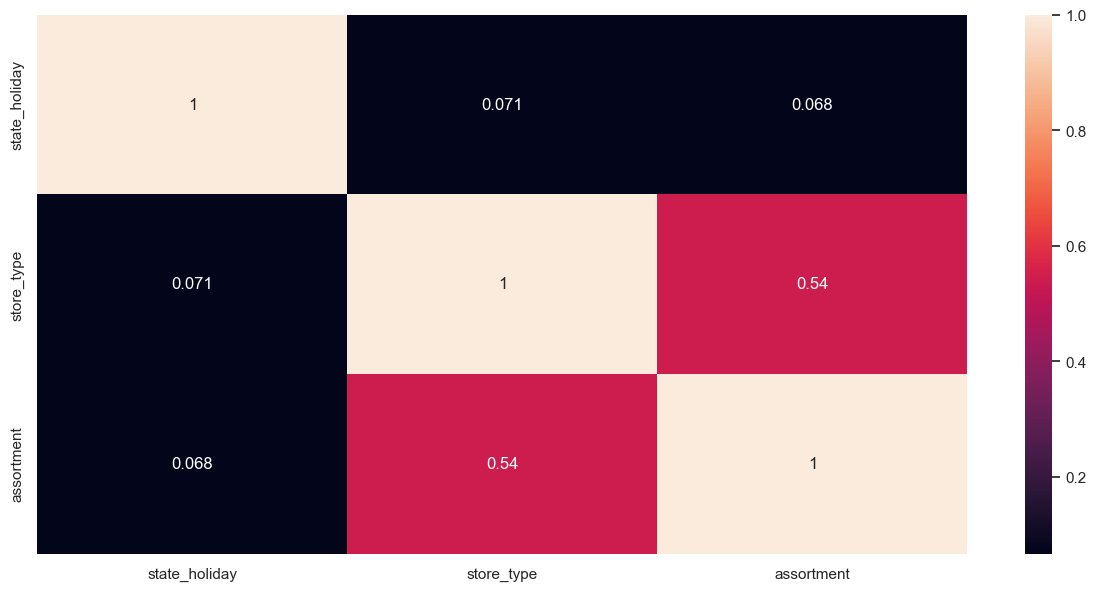

In [45]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday':[a1,a2,a3],
        'store_type':[a4,a5,a6],
        'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)


fig, axes = plt.subplots(1,1,figsize=(15,7))
sns.heatmap(d, annot = True, ax = axes);

# 5.0 Data Preparation

In [46]:
df2 = df1.copy()

## 5.1 Normalização

Não foram encontrados dados para normalização (falta dist Gaussiana nos dados)

## 5.2 Rescaling

In [47]:
a = df2.select_dtypes(include=['float64','int64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


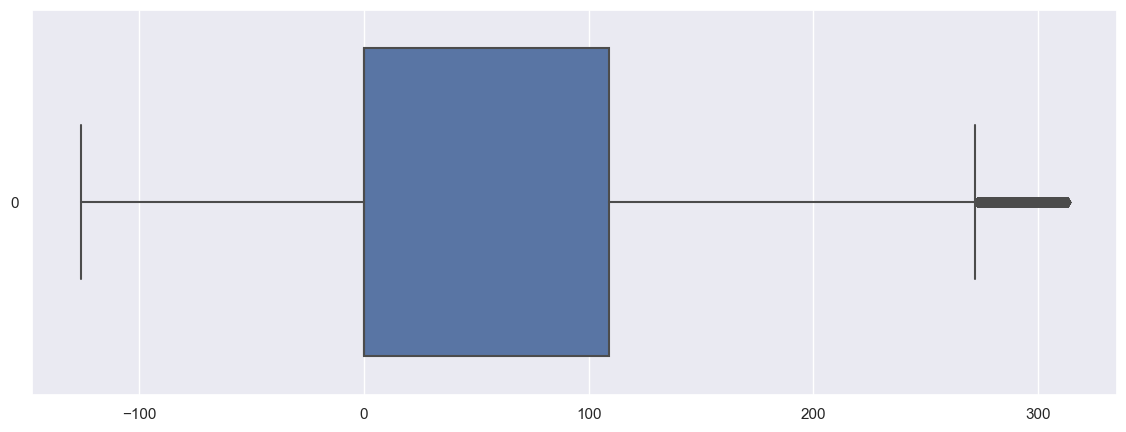

In [48]:
fig, axes = plt.subplots(1,1, figsize=(14,5))
sns.boxplot(df2['promo_time_week'], orient='h', ax = axes);

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df2['competition_distance'] = rs.fit_transform( df2[['competition_distance']].values )


# competition time month
df2['competition_time_month'] = rs.fit_transform( df2[['competition_time_month']].values )

# promo time week
df2['promo_time_week'] = mms.fit_transform( df2[['promo_time_week']].values )

# year
df2['year'] = mms.fit_transform( df2[['year']].values )


## 5.3 Transformação

### 5.3.1 Encoding

In [50]:
df2.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [51]:
# state_holiday - one_hot_encoding
df2 = pd.get_dummies(df2, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label_encoding
le = LabelEncoder()
df2['store_type'] = le.fit_transform(df2['store_type'])

# assortment - ordinal_encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df2['assortment'] = df2['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

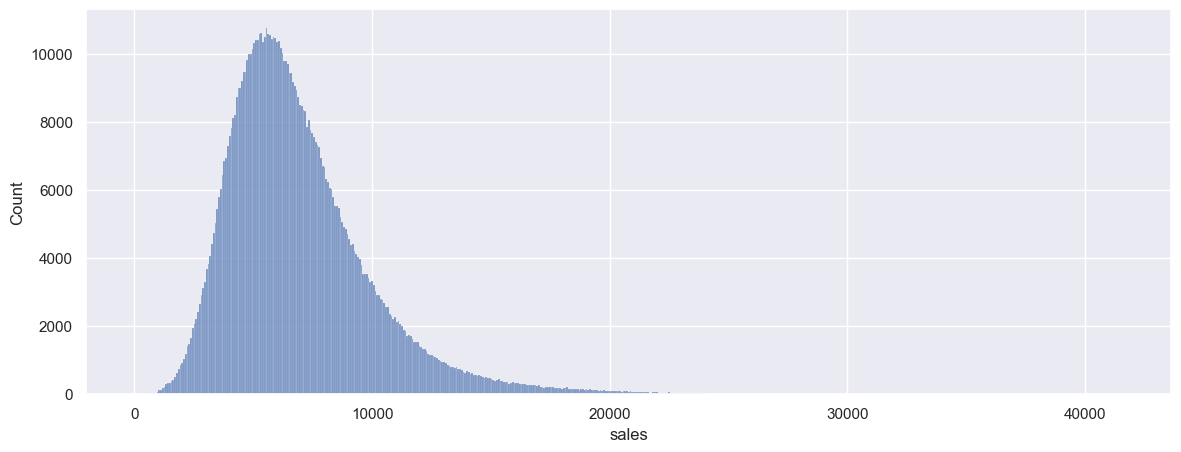

In [52]:
fig, axes = plt.subplots(1,1,figsize = (14,5))
sns.histplot(df2['sales'], ax = axes);

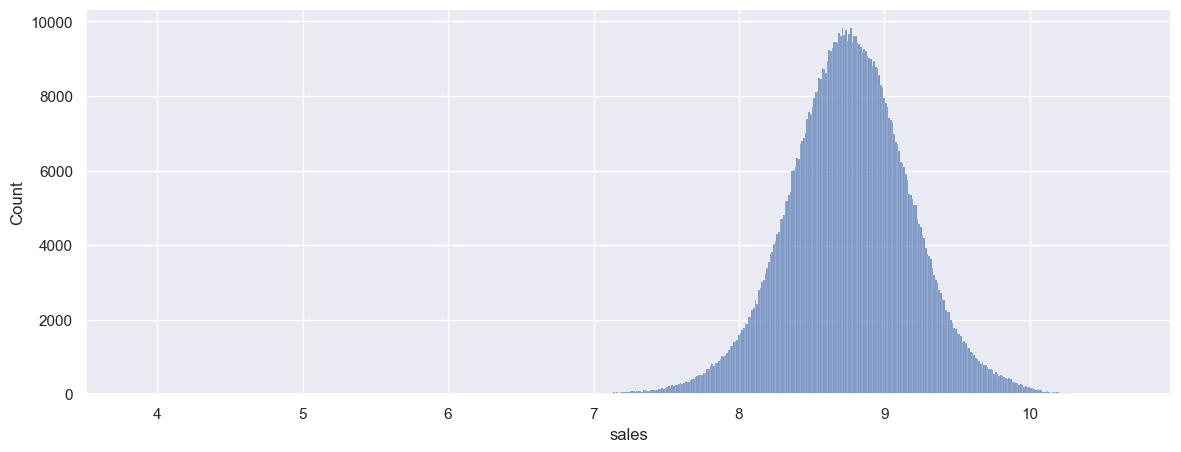

In [53]:
fig, axes = plt.subplots(1,1,figsize = (14,5))
df2['sales'] = np.log1p( df2['sales'] )
sns.histplot(df2['sales'], ax = axes);

### 5.3.3 Nature Transformation

In [54]:
# day of week
df2['day_of_week_sin'] = df2['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi / 7 ) ) )
df2['day_of_week_cos'] = df2['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi / 7 ) ) )


# month
df2['month_sin'] = df2['month'].apply( lambda x: np.sin( x * (2 * np.pi / 12 ) ) )
df2['month_cos'] = df2['month'].apply( lambda x: np.cos( x * (2 * np.pi / 12 ) ) )

# day
df2['day_sin'] = df2['day'].apply( lambda x: np.sin( x * (2 * np.pi / 30 ) ) )
df2['day_cos'] = df2['day'].apply( lambda x: np.cos( x * (2 * np.pi / 30 ) ) )

# week of year
df2['week_of_year_sin'] = df2['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi / 52 ) ) )
df2['week_of_year_cos'] = df2['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi / 52 ) ) )

In [55]:
df2.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## Resumo Seleção Univariada

In [56]:
quadro = [['Variavel Preditora \\ Resposta','CONTÍNUA','CATEGÓRICA'],
['CONTÍNUA', 'Correlação de Pearson','Linear Discriminant Analysis (LDA)'],
['CATEGÓRICA', 'ANOVA', 'Chi-Square / Cramer V']
]
print(tabulate(quadro, headers= 'firstrow'))

Variavel Preditora \ Resposta    CONTÍNUA               CATEGÓRICA
-------------------------------  ---------------------  ----------------------------------
CONTÍNUA                         Correlação de Pearson  Linear Discriminant Analysis (LDA)
CATEGÓRICA                       ANOVA                  Chi-Square / Cramer V


# 6 Feature Selection

In [57]:
df3 = df2.copy()

## 6.1 Split in training/test dataset

In [58]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df3 = df3.drop(cols_drop, axis = 1)

In [59]:
df3[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
# train
x_train = df3.loc[df3['date'] < '2015-06-19']
y_train = x_train['sales']

print('Data mínima de treino: {} e data máxima de treino: {}'.format(x_train['date'].min(),x_train['date'].max()))


# test
x_test = df3.loc[df3['date'] >= '2015-06-19']
y_test = x_test['sales']
print('Data mínima de teste: {} e data máxima de teste: {}'.format(x_test['date'].min(),x_test['date'].max()))

Data mínima de treino: 2013-01-01 00:00:00 e data máxima de treino: 2015-06-18 00:00:00
Data mínima de teste: 2015-06-19 00:00:00 e data máxima de teste: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [66]:
# train/test for Boruta
x_train_n = x_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# define random forest regressor
rf = RandomForestRegressor( n_jobs = -1)

# define boruta selector
# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0


### 6.2.1 Best features from Boruta

In [65]:
# cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['date','sales'], axis = 1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                'month_cos','month_sin','day_sin','day_cos','week_of_year_sin','week_of_year_cos']

# not selected
cols_not_selected_boruta = list(np.setdiff1d( x_train_fs.columns, cols_selected_boruta ))

In [66]:
# columns to add
feat_to_add = ['date','sales']

cols_selected_boruta.extend(feat_to_add)

In [67]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']